# Pokemon Generator
* Made by: Ampiro
* Date: 05.07.2022
* based on [article](https://arxiv.org/pdf/1511.06434.pdf)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import cv2
import torchvision

from tqdm.notebook import tqdm
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [26]:
path = ""
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
# Run this section if you use Colab
"""
! mkdir /content/kaggle 
! mkdir ~/.kaggle/
! echo '{"username":"patratskiimaxim","key":"f084af1e6ebfe2d778a96020a9dd1bf8"}' > ~/.kaggle/kaggle.json 
! chmod 600 ~/.kaggle/kaggle.json 
! kaggle datasets download -d hlrhegemony/pokemon-image-dataset -p /content/kaggle/
import zipfile
with zipfile.ZipFile("/content/kaggle/pokemon-image-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/kaggle/")
    
path = /content/kaggle/
"""
pass

# Dataset class

In [59]:
class PokemonDataset(Dataset):
    def __init__(self, path="/content/kaggle/images"):
        super().__init__()
        self.images = []

        pathlist = list(Path(path).glob('**/*.jpg'))

        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),                                        
            torchvision.transforms.Resize((64, 64)),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),                                           
        ])

        for path in tqdm(pathlist):
            img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = transform(img)
            self.images += [img]

        
    def __getitem__(self, index):
        return self.images[index]

    def __len__(self):
        return len(self.images)

In [60]:
def plot(img_list, one_sample=False):
    if not one_sample:
        for j in range(len(img_list)):
            fig, ax = plt.subplots(4, 4, figsize=(15, 15))
            for i, img in enumerate(img_list[j]):
                ax[i//4, i%4].imshow((img.permute((1, 2, 0))))
                ax[i//4, i%4].axis('off')
            plt.show()
    else:
        fig, ax = plt.subplots(len(img_list)//4 + 1, 4, figsize=(8, len(img_list)/2))
        for i, img in enumerate(img_list):
            ax[i//4, i%4].imshow(((img[0]+1)/2).permute((1, 2, 0)))
            ax[i//4, i%4].axis('off')
        plt.show()


In [61]:
# data = PokemonDataset() # for collab use
data = PokemonDataset(path="images")
batch_size = 64
loader_train = DataLoader(data, batch_size=batch_size, shuffle=True)

  0%|          | 0/2503 [00:00<?, ?it/s]

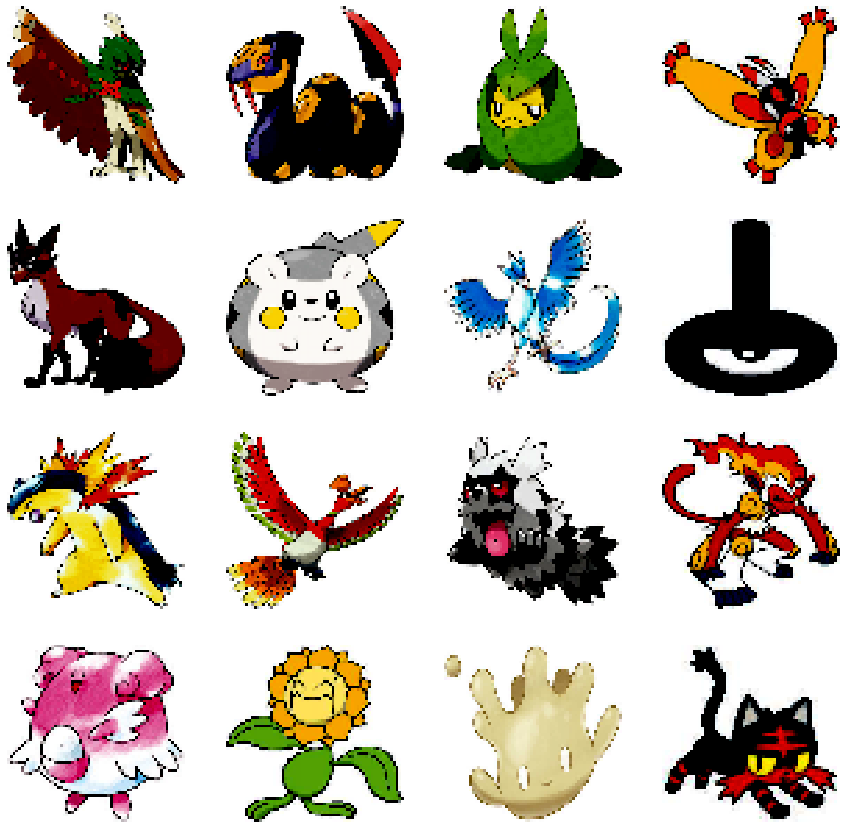

In [62]:
examples = next(iter(loader_train))
plot([examples[0:16].clamp(0,1)])

# Generator

In [63]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, X):
        return self.main(X)

# Discriminator

In [64]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4,2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, X):
        return self.main(X)

# Additional functions

In [65]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [66]:
def GeneratorLoss(logits_fake):
    return nn.BCELoss()(logits_fake, torch.ones_like(logits_fake)) / len(logits_fake)

In [67]:
def DiscriminatorLoss(logits_real, logits_fake):    
    real_loss = nn.BCELoss()(logits_real,torch.ones_like(logits_real))/len(logits_real)
    fake_loss = nn.BCELoss()(logits_fake, torch.zeros_like(logits_fake))/len(logits_fake)
    total_loss = real_loss + fake_loss
    return total_loss

In [68]:
def NoiseSampler(num = 1):
    return torch.randn(num, 100, 1, 1, device=device)

# Training loop

In [69]:
def TrainingLoop(
    G : nn.Module, opt_G : torch.optim.Optimizer,
    D : nn.Module, opt_D : torch.optim.Optimizer,
    loader_train: torch.utils.data.DataLoader,
    batch_size=128,
    num_epochs=10,
    show_period=256,
    path=""):

    iters = 0
    images = []
    
    G_losses = []
    D_losses = []
    
    for epoch in range(num_epochs):
        with tqdm(total=len(loader_train), 
                  desc='Training on '+str(epoch+1)+'/'+str(num_epochs)+' epoch ') as pbar:
            for img in loader_train:
                if len(img) != batch_size:
                    pbar.update(1)
                    iters += 1
                    continue
                
                z = NoiseSampler(num=batch_size)
                img = img.to(device)
                img_gen = G(z)
                
                logits_real = D(img)
                logits_fake = D(img_gen.detach())
                
                opt_D.zero_grad()
                D_loss = DiscriminatorLoss(logits_real, logits_fake)
                D_loss.backward()
                opt_D.step()
                
                logits_fake = D(img_gen)

                opt_G.zero_grad()
                G_loss = GeneratorLoss(logits_fake)
                G_loss.backward()
                opt_G.step()
                
                D_losses += [D_loss.cpu().item()]
                G_losses += [G_loss.cpu().item()]

                if (iters + 1) % show_period == 0:
                    images += [img_gen[0:16].cpu().data]
                    
                iters += 1
                pbar.update(1)


    torch.save(G, path+"G")
    torch.save(D, path+"D")
    return G_losses, D_losses, images

# Training

In [70]:
G = Generator().to(device)
D = Discriminator().to(device)

print("Params in G: ", sum(p.numel() for p in G.parameters()))
print("Params in D: ", sum(p.numel() for p in D.parameters()))

Params in G:  3576704
Params in D:  2765568


In [71]:
G.apply(weights_init)
D.apply(weights_init)
G.train()
D.train()
opt_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [72]:
GL, DL, generated_images = TrainingLoop(
    G, opt_G,
    D, opt_D,
    loader_train,
    batch_size=batch_size,
    num_epochs=50,
    show_period=10,
    path=path
)

Training on 1/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 2/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 3/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 4/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 5/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 6/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 7/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 8/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 9/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 10/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 11/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 12/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 13/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 14/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 15/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 16/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 17/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 18/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 19/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 20/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 21/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 22/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 23/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 24/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 25/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 26/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 27/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 28/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 29/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 30/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 31/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 32/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 33/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 34/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 35/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 36/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 37/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 38/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 39/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 40/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 41/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 42/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 43/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 44/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 45/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 46/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 47/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 48/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 49/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

Training on 50/50 epoch :   0%|          | 0/40 [00:00<?, ?it/s]

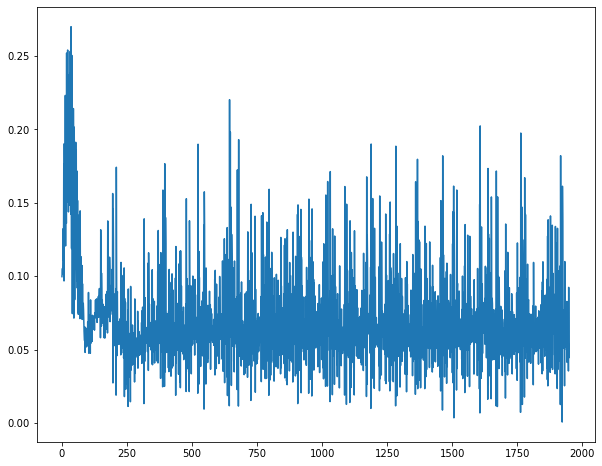

In [73]:
plt.plot(GL)

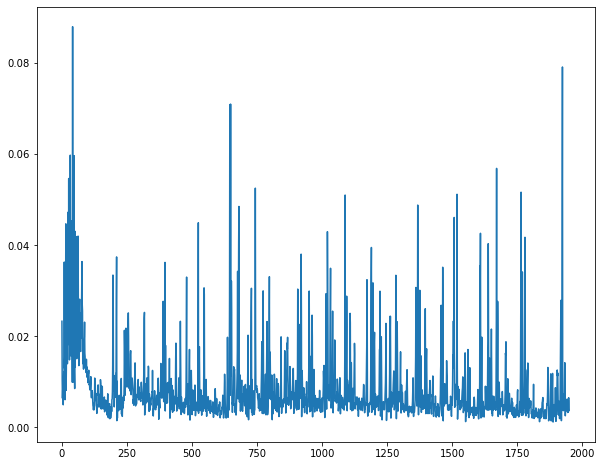

In [74]:
plt.plot(DL)

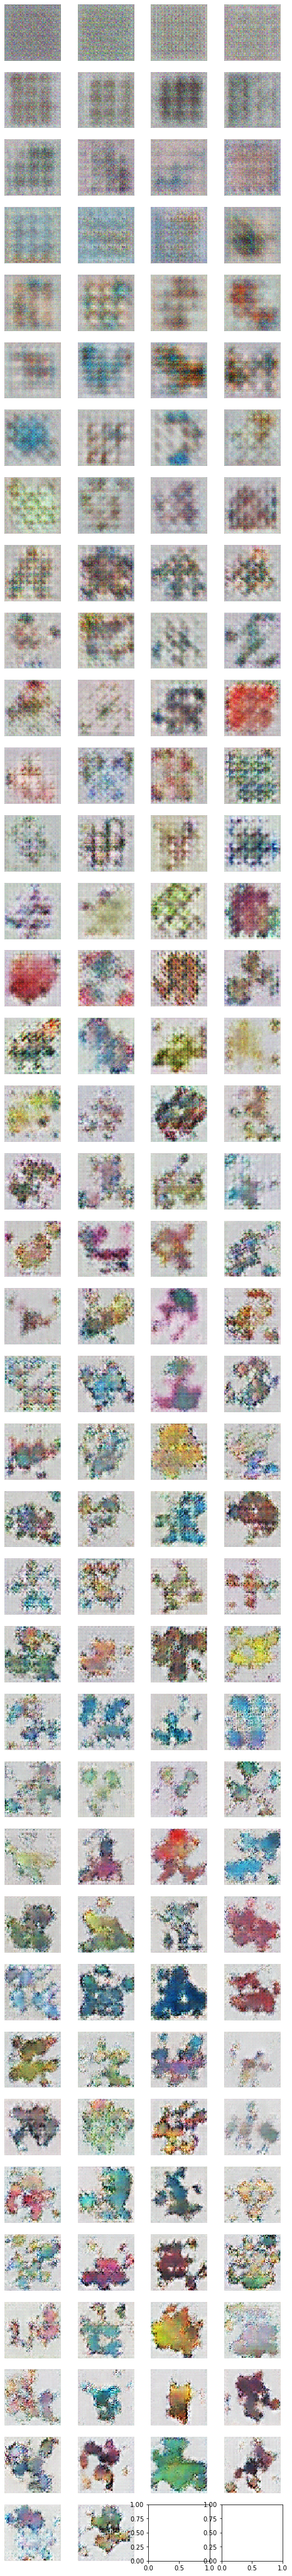

In [75]:
plot(generated_images, one_sample = True)

# Results 

In [82]:
best_G = Generator()
best_G = torch.load(path+"G")
best_G.eval()
pass

In [83]:
z = NoiseSampler(16)
images = best_G(z).detach().cpu()

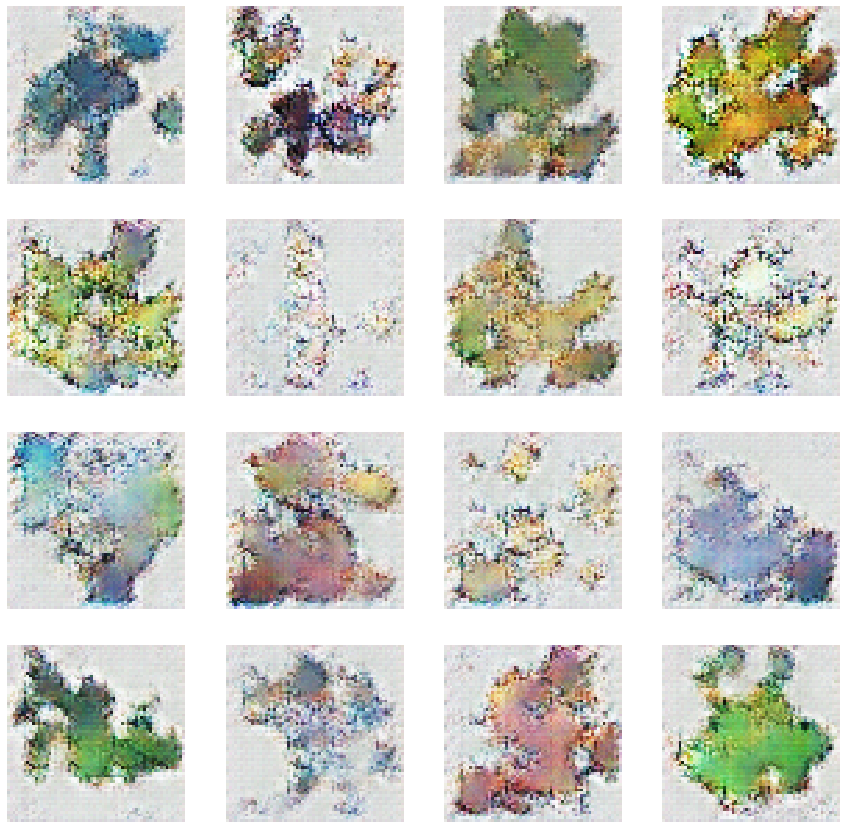

In [84]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for i, img in enumerate(images):
    ax[i//4, i%4].imshow(((img.permute((1, 2, 0)))+1)/2)
    ax[i//4, i%4].axis('off')
plt.show()